In [2]:
import pandas as pd
import numpy as np
import pymc3 as pm
import theano
import theano.tensor as tt
import arviz as az
import matplotlib.pyplot as plt
from itertools import product as outer
import scipy.stats as stats

%matplotlib inline
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"

# Load Data

In [3]:
data = pd.read_table("tmuris.coverage.partial.clean800.tsv.gz")
data.head()

chromosome  position  counts       batch   gene     txEnd  distance
0      chr11  84401150       1  SRR6835844  Acaca  84401664       514
1      chr11  84401159       1  SRR6835844  Acaca  84401664       505
2      chr11  84401160       1  SRR6835844  Acaca  84401664       504
3      chr11  84401176       1  SRR6835844  Acaca  84401664       488
4      chr11  84401188       1  SRR6835844  Acaca  84401664       476

In [4]:
data.batch.unique()

array(['SRR6835844', 'SRR6835845', 'SRR6835846', 'SRR6835847',
       'SRR6835848', 'SRR6835849', 'SRR6835850', 'SRR6835851',
       'SRR6835852', 'SRR6835853', 'SRR6835854', 'SRR6835855',
       'SRR6835856', 'SRR6835857', 'SRR6835858', 'SRR6835859',
       'SRR6835860', 'SRR6835861', 'SRR6835862', 'SRR6835863',
       'SRR6835864', 'SRR6835865', 'SRR6835866', 'SRR6835867',
       'SRR6835868', 'SRR6835869', 'SRR6835870', 'SRR6835871'],
      dtype=object)

In [5]:
data.gene.unique()

array(['Acaca', 'Aplp2', 'Asb6', 'Bcas3', 'Bcl2l1', 'C2cd2l', 'Calm3',
       'Ccdc92', 'Cd151', 'Cd2bp2', 'Chmp3', 'Clip2', 'Cog6', 'Dedd',
       'Entpd6', 'Fam193a', 'Fbxw8', 'Fitm2', 'Fnip1', 'Gabarapl1',
       'Gnb1', 'Golga2', 'Kat7', 'Lrpap1', 'Lrrc59', 'Map1lc3b', 'Mau2',
       'Metap1', 'Mllt11', 'Nab2', 'Ncln', 'Ncor2', 'Ndrg3', 'Otud4',
       'Pcbp4', 'Prosc', 'Pttg1ip', 'Pxn', 'Rapgef6', 'Sec61a1', 'Sep15',
       'Sh2b3', 'Stard7', 'Tmed1', 'Tmub1', 'Ttbk2', 'Ube2z', 'Ube3b',
       'Ubqln4', 'Vamp2', 'Vamp3', 'Vps9d1', 'Wdr5', 'Ywhah', 'Zfp444',
       'Zfp64'], dtype=object)

# Plot some raw data

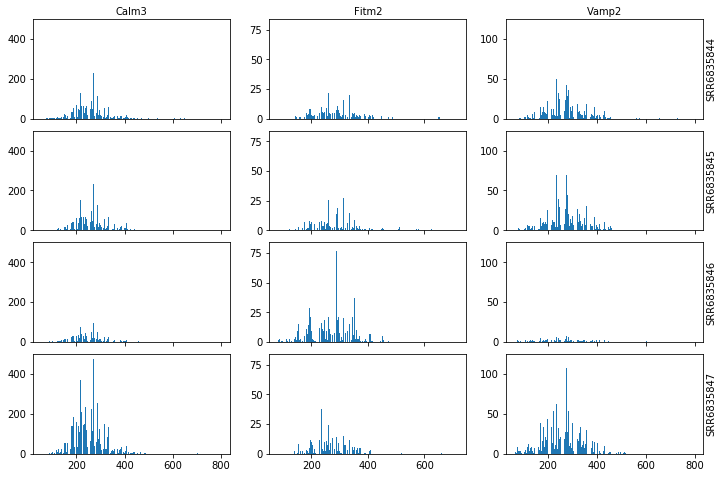

In [10]:
genes = ['Calm3', 'Fitm2', 'Vamp2']
batches = ['SRR6835844', 'SRR6835845', 'SRR6835846', 'SRR6835847']
B, G = len(batches), len(genes)

f, axs = plt.subplots(B, G, figsize=(12, 8), sharex='col', sharey='col')
for (i,j) in outer(range(B), range(G)):
    b, g = batches[i], genes[j]
    d_gb = data.loc[(data.gene == g) & (data.batch == b), :]
    axs[i, j].bar(x=d_gb.distance, height=d_gb.counts)
    if i == 0:
        axs[i,j].set(xlabel=g)
        axs[i,j].xaxis.set_label_position("top")

    if j == G - 1:
        axs[i,j].set(ylabel=b)
        axs[i,j].yaxis.set_label_position("right")
        

f.subplots_adjust(hspace=0.12)
plt.show()

# Aggregate Data

In [11]:
data_agg = data.groupby(['batch', 'distance']).agg({'counts': 'sum'}).reset_index()

X = pd.get_dummies(data_agg.batch)
Y = data_agg.distance.values
W = data_agg.counts.values

data_agg.head()

batch  distance  counts
0  SRR6835844        59       2
1  SRR6835844        60       1
2  SRR6835844        61       6
3  SRR6835844        62       4
4  SRR6835844        63      13

## Plot raw aggregated data

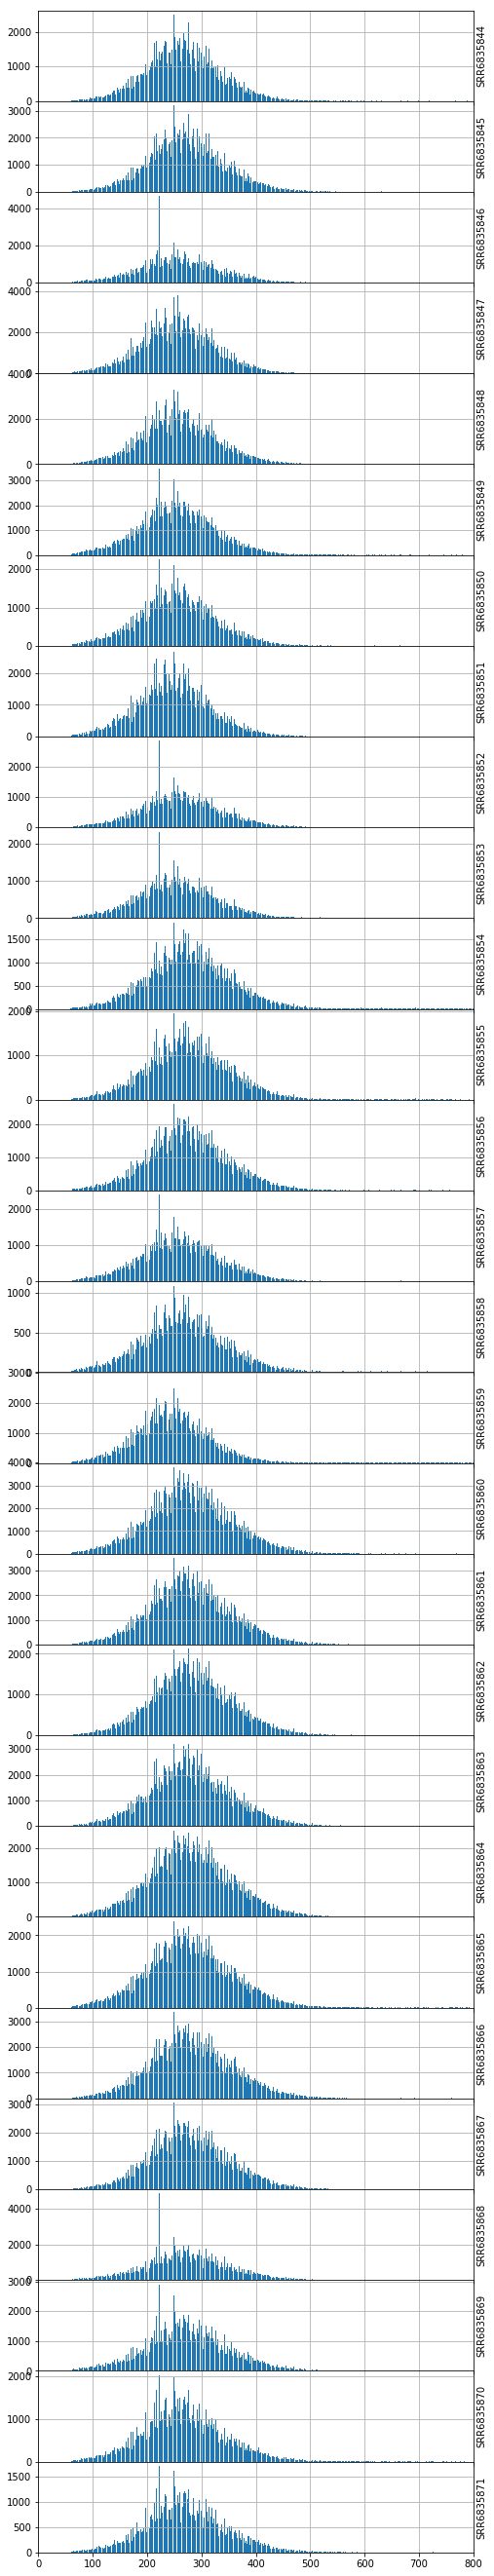

In [13]:
B = data_agg.batch.nunique()

f, axs = plt.subplots(B, figsize=(8, 48), sharex='col', dpi=300)
axs[0].set_xlim(left=0, right=800)

for i in range(B):
    b = data_agg.batch.unique()[i]
    d_b = data_agg.loc[data_agg.batch == b, :]
    axs[i].bar(x=d_b.distance, height=d_b.counts)
    axs[i].set(ylabel=b)
    axs[i].yaxis.set_label_position("right")
    axs[i].grid(True)

f.subplots_adjust(hspace=0)
plt.show()

# Modeling
NUTS is having trouble getting started, so we will start with a medium length Metropolis-Hastings run to get an initial picture of what could be bottlenecking the process.

In [16]:
with pm.Model() as m1:
    sigma_all = pm.Normal('sigma_all', mu=80, sd=5)
    alpha = pm.HalfNormal('alpha', sd=1, shape=X.shape[1])
    mu_all = pm.Normal('mu_all', mu=270, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=X.shape[1])
    
    sigma = sigma_all + pm.math.dot(X, alpha)
    mu = mu_all + pm.math.dot(X, beta)
    
    y = pm.Potential('y_logp_weighted', W*pm.Gamma.dist(mu=mu, sd=sigma).logp(Y))
    
    trace_m1 = pm.sample(10000, tune=10000, chains=4, cores=8, step=pm.Metropolis())

Multiprocess sampling (4 chains in 8 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [mu_all]
>Metropolis: [alpha]
>Metropolis: [sigma_all]
Sampling 4 chains: 100%|██████████| 80000/80000 [06:52<00:00, 194.01draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [17]:
pm.summary(trace_m1)

mean        sd  mc_error     hpd_2.5    hpd_97.5      n_eff  \
sigma_all   75.935942  0.498697  0.049729   75.356581   77.298371   7.146024   
mu_all     270.359119  0.140841  0.013175  270.018262  270.631625  13.031921   
beta__0     -1.867910  0.363322  0.034014   -2.558070   -1.061125   8.022556   
beta__1      2.751492  0.294211  0.027004    2.093423    3.318702  13.718528   
beta__2    -11.242624  0.228492  0.017443  -11.655386  -10.754465  38.722415   
beta__3    -12.022361  0.365928  0.034997  -12.638223  -11.123824   7.472348   
beta__4     -8.772016  0.360514  0.034222   -9.371756   -7.895827   7.622158   
beta__5    -14.249793  0.528730  0.051423  -15.231846  -13.521640   2.590577   
beta__6    -14.025012  0.369953  0.034564  -14.801693  -13.492692   2.933735   
beta__7    -19.356045  0.379837  0.035851  -20.001749  -18.441450   8.152178   
beta__8     -4.807227  0.225146  0.016771   -5.262300   -4.368482  44.294033   
beta__9    -12.678577  0.244999  0.019002  -13.147374  -12.154068  41.215323   
beta__10     9.779605  0.225099  0.017120    9.369176   10.268283  33.523389   
beta__11     7.696928  0.229268  0.017829    7.253766    8.164158  30.208566   
beta__12     8.059102  0.194688  0.014461    7.681234    8.464704  25.688853   
beta__13    -7.135024  1.552511  0.154530  -10.004020   -5.846742   2.030878   
beta__14     0.503595  0.266022  0.020734   -0.040571    1.029768  33.489236   
beta__15   -19.605783  0.331129  0.030585  -20.273333  -18.827382  13.348974   
beta__16     9.898162  0.828794  0.081913    7.172081   10.520521   8.006552   
beta__17    10.107567  0.187240  0.014773    9.715828   10.461966  31.627489   
beta__18    13.793345  0.196268  0.014725   13.397544   14.169764  43.147620   
beta__19    10.842874  0.173643  0.013242   10.511420   11.198187  28.230216   
beta__20    11.491457  0.193316  0.014788   11.112645   11.873538  31.723672   
beta__21     9.312924  0.202594  0.015532    8.915780    9.729150  20.916126   
beta__22    13.349056  0.186891  0.014372   12.984571   13.715398  16.845445   
beta__23     9.659944  0.196591  0.015491    9.290535   10.078048  29.011071   
beta__24     4.026563  0.211961  0.016453    3.627123    4.462842  28.910737   
beta__25     4.125294  0.228500  0.017768    3.667569    4.590677  31.096123   
beta__26    -0.883959  0.213440  0.015708   -1.275998   -0.434919  43.842761   
beta__27     1.857558  0.846963  0.083364    0.194339    2.766344   2.127380   
alpha__0     0.038615  0.014534  0.001447    0.016464    0.064211   3.048131   
alpha__1     0.736840  0.620287  0.061950    0.029064    1.666084   2.455554   
alpha__2     4.871965  0.512163  0.049788    3.597141    5.614145   7.566069   
alpha__3     0.019553  0.008546  0.000851    0.006380    0.040541   2.674636   
alpha__4     0.050191  0.028525  0.002847    0.015912    0.099742   2.208461   
alpha__5     0.877149  0.620357  0.061933    0.033217    1.746872   3.283919   
alpha__6     1.601367  0.955600  0.095402    0.095797    2.697253   2.701789   
alpha__7     0.025232  0.013796  0.001376    0.004865    0.048677   2.347485   
alpha__8     7.101366  0.526998  0.050655    5.757060    7.899595   8.033082   
alpha__9     5.311445  0.500369  0.048662    4.048114    6.089399   7.945593   
alpha__10    8.929683  0.516589  0.050058    7.621635    9.689471   7.609898   
alpha__11    8.535550  0.499914  0.048435    7.254590    9.267791   7.609075   
alpha__12    7.028591  0.495098  0.048322    5.731757    7.720019   7.348848   
alpha__13    5.302279  3.098419  0.309616    0.007247    7.684874   2.042904   
alpha__14    9.687445  0.527770  0.049910    8.329921   10.498163   7.871529   
alpha__15    0.251987  0.229354  0.022905    0.039052    0.738638   2.235811   
alpha__16    7.273662  2.136187  0.213086    0.032284    8.427409   8.587028   
alpha__17    5.580055  0.515805  0.050665    4.271900    6.293192   7.409041   
alpha__18    4.753272  0.515252  0.050458    3.467822    5.503325   7.501672   
alpha__19    6.33

Worth noting here is that the posterior scale on most variables is on the same order of magnitude.  However, the number of effective samples is quite poor, with the split $\hat{R}$ indicating lack of aggreement across chains.

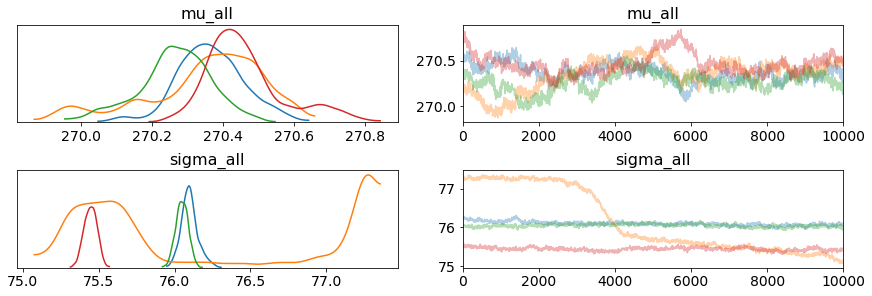

In [19]:
az.plot_trace(trace_m1, var_names=['mu_all', 'sigma_all'])
plt.show()

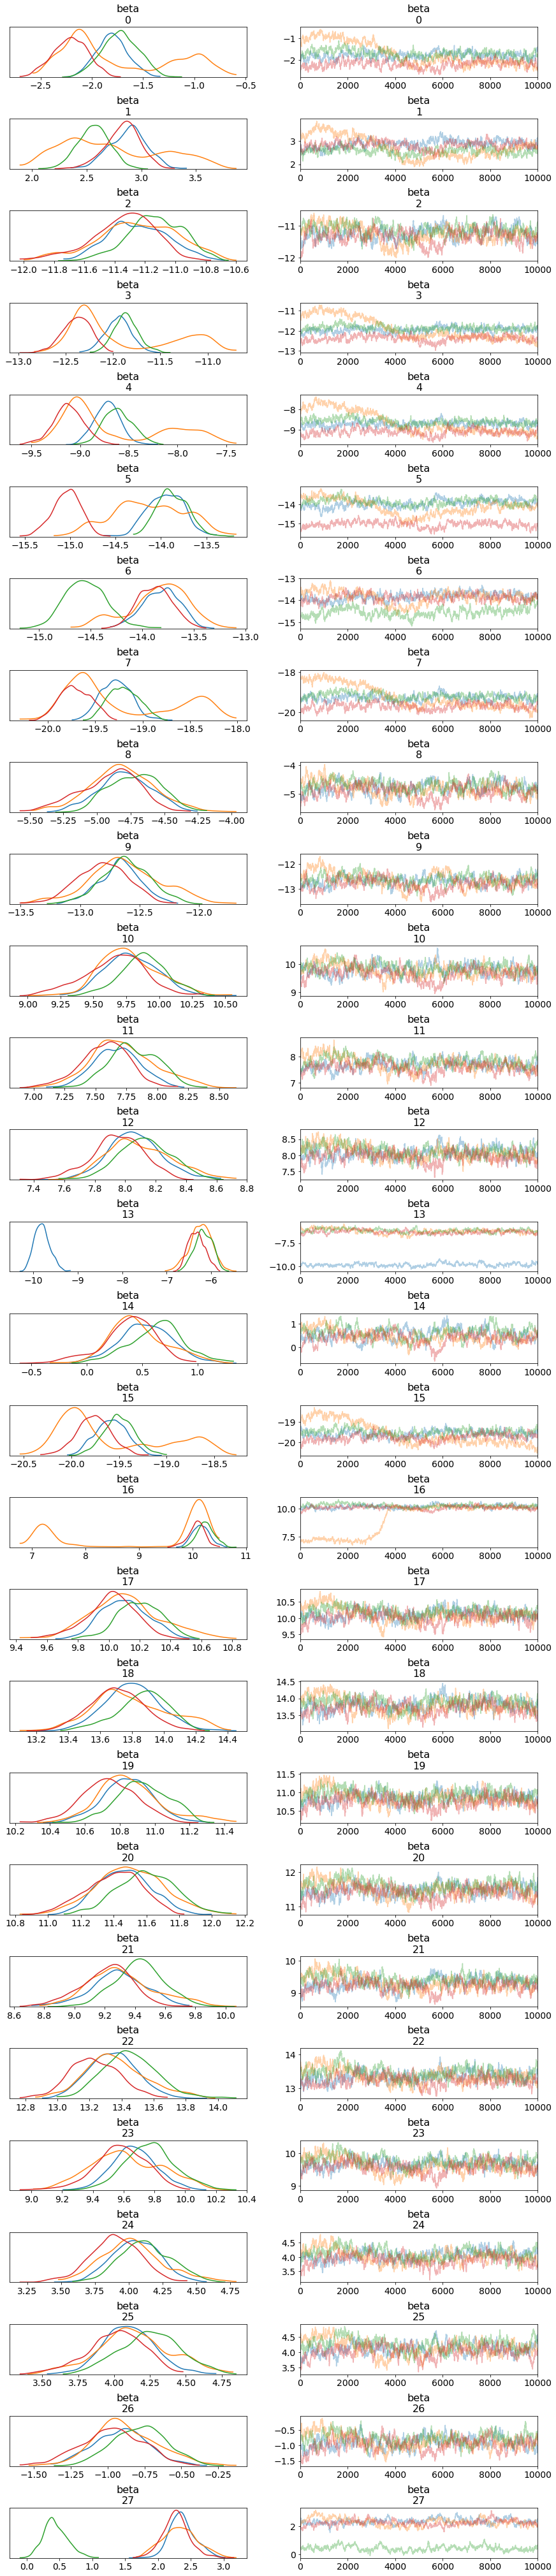

In [20]:
az.plot_trace(trace_m1, var_names=['beta'])
plt.show()

We can clearly see one of the chains appeared trapped in a location that differed strongly from the other chains. For this reason, it seems justified to regard all the data up to that switch to be *burn-in*.  Let's truncate the data there, compute new means, and then start a new run initialized to the means.

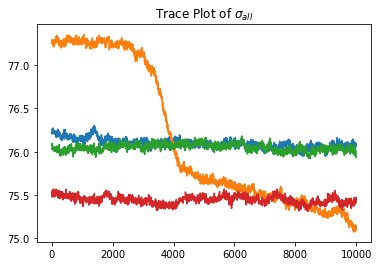

In [21]:
# just checking that the reshaping order I use recapitulates the trace above
plt.plot(trace_m1['sigma_all'].reshape((10000,4), order='F'))
plt.title("Trace Plot of $\sigma_{all}$")
plt.show()

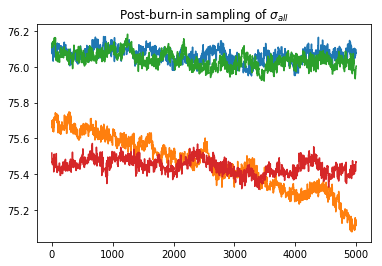

In [24]:
plt.plot(trace_m1['sigma_all'].reshape((10000,4), order='F')[5000:,:])
plt.title("Post-burn-in sampling of $\sigma_{all}$")
plt.show()

### Extracting mean values using iterations 5K-10K

In [25]:
alpha_hat = trace_m1.get_values('alpha', combine=True).reshape((10000,4,28), order='F')[5000:,:,:].mean(axis=(0,1))
beta_hat = trace_m1.get_values('beta', combine=True).reshape((10000,4,28), order='F')[5000:,:,:].mean(axis=(0,1))
mu_all_hat = trace_m1['mu_all'].reshape((10000,4), order='F')[5000:,:].mean()
sigma_all_hat = trace_m1['sigma_all'].reshape((10000,4), order='F')[5000:,:].mean()

## Plot data with fitted distributions

In [26]:
def gamma_reparam(mu, sd):
    """
    Conversion method for parameterizing `scipy.stats.gamma` using mean and standard deviation.
    """
    a = mu**2/sd**2
    scale = sd**2/mu
    
    return a, scale

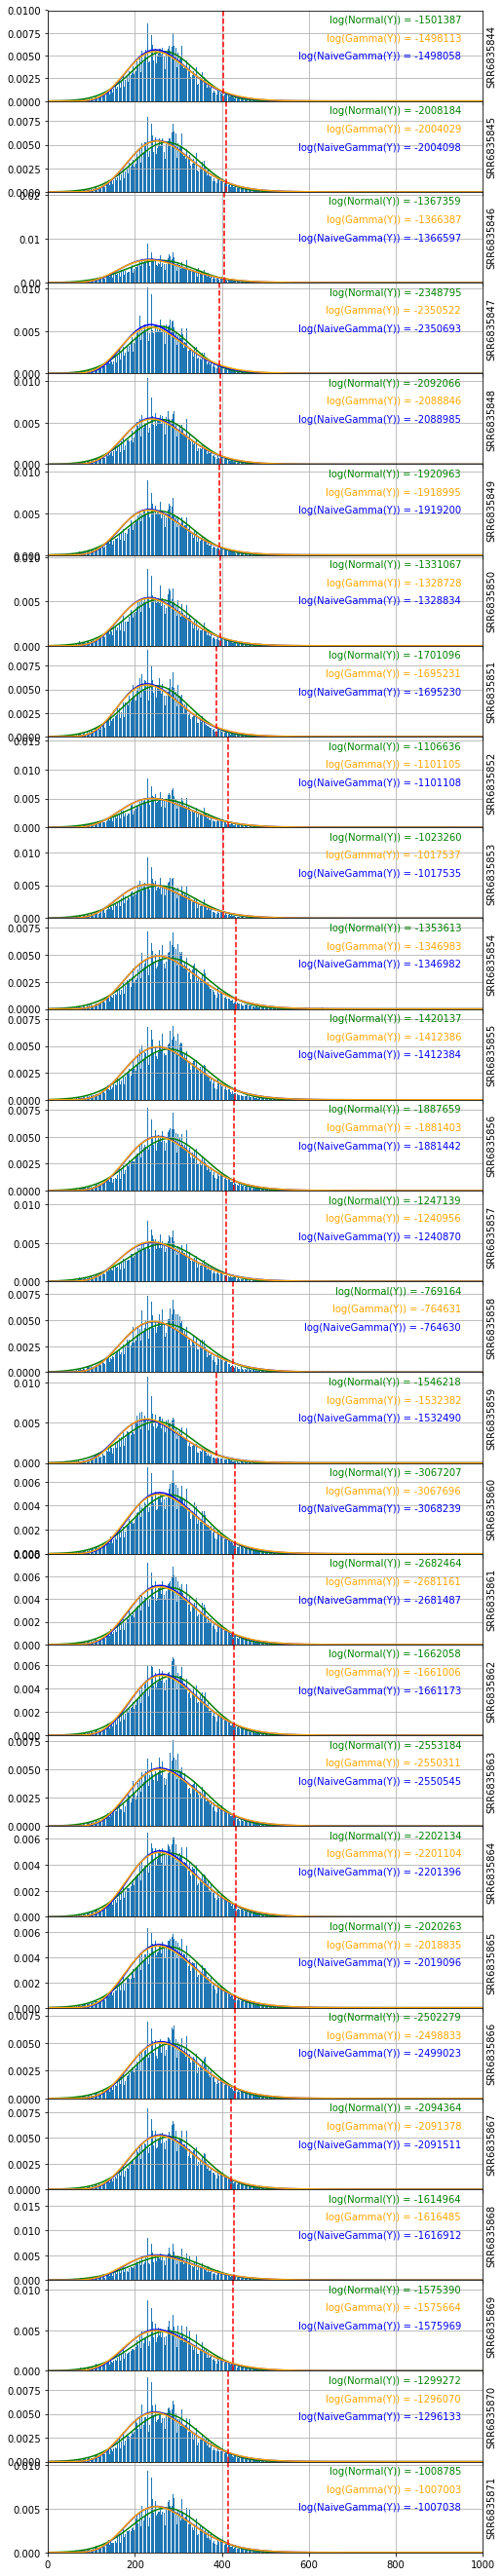

In [27]:
B = data_agg.batch.nunique()
X_plt = np.linspace(0,1000, 200)

f, axs = plt.subplots(B, figsize=(8, 48), sharex='col')
axs[0].set_xlim(left=0, right=1000)

for i in range(B):
    b = data_agg.batch.unique()[i]
    d_b = data_agg.loc[data_agg.batch == b, :]
    axs[i].bar(x=d_b.distance, height=d_b.counts/d_b.counts.sum())
    
    # Fitted Normal
    mu_raw = d_b.distance.dot(d_b.counts)/d_b.counts.sum()
    sd_raw = np.sqrt(d_b.counts.dot((d_b.distance - mu_raw)**2) / (d_b.counts.sum() - 1))
    Y_plt = stats.norm(loc=mu_raw, scale=sd_raw).pdf(X_plt)
    axs[i].plot(X_plt, Y_plt, color='green')
    
    loglik_norm = d_b.counts.dot(stats.norm(loc=mu_raw, scale=sd_raw).logpdf(d_b.distance))
    axs[i].text(0.95, 0.95, "log(Normal(Y)) = %d" % loglik_norm, 
                verticalalignment='top', horizontalalignment='right', 
                transform=axs[i].transAxes, color='green')
    
    # Naive Fitted Gamma
    a, scale = gamma_reparam(mu_raw, sd_raw)
    Y_plt = stats.gamma(a=a, scale=scale).pdf(X_plt)
    axs[i].plot(X_plt, Y_plt, color='blue')
    
    loglik_gamma2 = d_b.counts.dot(stats.gamma(a=a, scale=scale).logpdf(d_b.distance))
    axs[i].text(0.95, 0.55, "log(NaiveGamma(Y)) = %d" % loglik_gamma2, 
                verticalalignment='top', horizontalalignment='right', 
                transform=axs[i].transAxes, color='blue')
    
    # Fitted Gamma
    a, scale = gamma_reparam(mu_all_hat + beta_hat[i], sigma_all_hat + alpha_hat[i])
    Y_plt = stats.gamma(a=a, scale=scale).pdf(X_plt)
    axs[i].plot(X_plt, Y_plt, color='orange')
    
    loglik_gamma = d_b.counts.dot(stats.gamma(a=a, scale=scale).logpdf(d_b.distance))
    axs[i].text(0.95, 0.75, "log(Gamma(Y)) = %d" % loglik_gamma, 
                verticalalignment='top', horizontalalignment='right', 
                transform=axs[i].transAxes, color='orange')
    
    # 95% cutoff
    axs[i].axvline(x=stats.gamma(a=a, scale=scale).isf(0.05), color='r', linestyle='--')
    
    axs[i].set(ylabel=b)
    axs[i].yaxis.set_label_position("right")
    axs[i].grid(True)

f.subplots_adjust(hspace=0)
plt.show()

It appears the posterior gammas perform the best. However, it should be noted the other fits are using summary stats and not MLE distributions.

# Rerun from Previous Mean Positions

In [28]:
start_vals={'alpha': alpha_hat, 'beta': beta_hat, 'mu_all': mu_all_hat, 'sigma_all': sigma_all_hat}

with pm.Model() as m1_continued:
    sigma_all = pm.Normal('sigma_all', mu=80, sd=5)
    alpha = pm.HalfNormal('alpha', sd=1, shape=X.shape[1])
    mu_all = pm.Normal('mu_all', mu=270, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=X.shape[1])
    
    sigma = sigma_all + pm.math.dot(X, alpha)
    mu = mu_all + pm.math.dot(X, beta)
    
    y = pm.Potential('y_logp_weighted', W*pm.Gamma.dist(mu=mu, sd=sigma).logp(Y))
    
    trace_m1_continued = pm.sample(10000, tune=20000, chains=4, cores=8, start=start_vals, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 8 jobs)
NUTS: [beta, mu_all, alpha, sigma_all]
Sampling 4 chains: 100%|██████████| 120000/120000 [2:36:13<00:00, 12.80draws/s] 
There were 9650 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.13675873823744322, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8948599498471758, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


In [29]:
pm.summary(trace_m1_continued)

mean        sd  mc_error       hpd_2.5    hpd_97.5  \
sigma_all   74.743981  0.066010  0.002196  7.461562e+01   74.872208   
mu_all     270.367166  0.185588  0.007785  2.700184e+02  270.740883   
beta__0     -2.472619  0.227954  0.008116 -2.923720e+00   -2.033045   
beta__1      2.926834  0.223488  0.008009  2.470556e+00    3.338584   
beta__2    -11.251195  0.245353  0.008117 -1.172629e+01  -10.767827   
beta__3    -12.642270  0.214465  0.007976 -1.307569e+01  -12.233939   
beta__4     -9.025833  0.222190  0.008050 -9.468511e+00   -8.599881   
beta__5    -13.950952  0.223607  0.007779 -1.439579e+01  -13.520334   
beta__6    -13.796025  0.241535  0.008015 -1.428255e+01  -13.327551   
beta__7    -19.849096  0.226528  0.007755 -2.029856e+01  -19.415613   
beta__8     -4.830985  0.258554  0.008341 -5.358994e+00   -4.342256   
beta__9    -12.694442  0.259754  0.008073 -1.320535e+01  -12.184587   
beta__10     9.752662  0.251008  0.008214  9.273715e+00   10.253075   
beta__11     7.670609  0.245630  0.007030  7.188106e+00    8.148635   
beta__12     8.049896  0.231371  0.007716  7.598691e+00    8.497285   
beta__13    -6.276850  0.251776  0.007941 -6.776540e+00   -5.783577   
beta__14     0.512156  0.288952  0.009026 -7.289482e-02    1.059985   
beta__15   -19.645639  0.231970  0.007581 -2.009290e+01  -19.184274   
beta__16    10.148959  0.217110  0.007884  9.714270e+00   10.561647   
beta__17    10.102004  0.218593  0.007799  9.676669e+00   10.527509   
beta__18    13.793050  0.235910  0.008070  1.332327e+01   14.245109   
beta__19    10.836730  0.219414  0.007747  1.040980e+01   11.264853   
beta__20    11.483783  0.225068  0.007498  1.104443e+01   11.918978   
beta__21     9.301316  0.230427  0.007797  8.844108e+00    9.743939   
beta__22    13.323124  0.219899  0.007649  1.289012e+01   13.745262   
beta__23     9.652186  0.224539  0.007644  9.197924e+00   10.076647   
beta__24     4.028893  0.241160  0.008036  3.559800e+00    4.499888   
beta__25     4.122718  0.242044  0.008056  3.653637e+00    4.591775   
beta__26    -0.900958  0.246315  0.007835 -1.392615e+00   -0.431717   
beta__27     2.346403  0.258981  0.007538  1.834715e+00    2.848055   
alpha__0     0.021179  0.021159  0.000419  1.025383e-06    0.063502   
alpha__1     2.309165  0.118456  0.002702  2.079964e+00    2.543787   
alpha__2     6.056716  0.141638  0.002973  5.781314e+00    6.337047   
alpha__3     0.008113  0.007954  0.000096  7.236593e-07    0.023905   
alpha__4     0.766531  0.113814  0.002352  5.388867e-01    0.992085   
alpha__5     2.652827  0.118091  0.002679  2.416341e+00    2.878263   
alpha__6     3.242746  0.138843  0.002940  2.969125e+00    3.511770   
alpha__7     0.290350  0.117457  0.002488  5.818513e-02    0.512746   
alpha__8     8.285191  0.158601  0.003815  7.974337e+00    8.595483   
alpha__9     6.471563  0.158688  0.002698  6.155695e+00    6.775361   
alpha__10   10.100087  0.147962  0.003038  9.816492e+00   10.393361   
alpha__11    9.707420  0.145874  0.002774  9.428041e+00   10.002826   
alpha__12    8.205689  0.127736  0.002893  7.952463e+00    8.455202   
alpha__13    8.182771  0.148329  0.002412  7.893377e+00    8.475465   
alpha__14   10.860473  0.187216  0.004467  1.049753e+01   11.236723   
alpha__15    1.390087  0.128229  0.002409  1.139148e+00    1.645818   
alpha__16    8.987296  0.110083  0.002932  8.769837e+00    9.201310   
alpha__17    6.774691  0.110934  0.002518  6.557572e+00    6.991120   
alpha__18    5.940912  0.131730  0.002514  5.694470e+00    6.213057   
alpha__19    7.526864  0.112621  0.002523  7.301943e+00    7.742814   
alpha__20    8.782446  0.121155  0.002684  8.540538e+00    9.016230   
alpha__21    9.517475  0.124849  0.002713  9.274430e+00    9.762682   
alpha__22    7.520697  0.112087  0.002583  7.301965e+00    7.738756   
alpha__23    4.279765  0.117310  0.002820  4.051355e+00    4.510480   
alpha__24   10.113723  0.136478  0.002927  9.847674e+00   10.382742   
alpha__25    8.859697  0.138662  0.003051

Despite the complaints about effective sample size, the overall sampling looks significantly improved compared to previously. All values appear converged.

### Alpha values

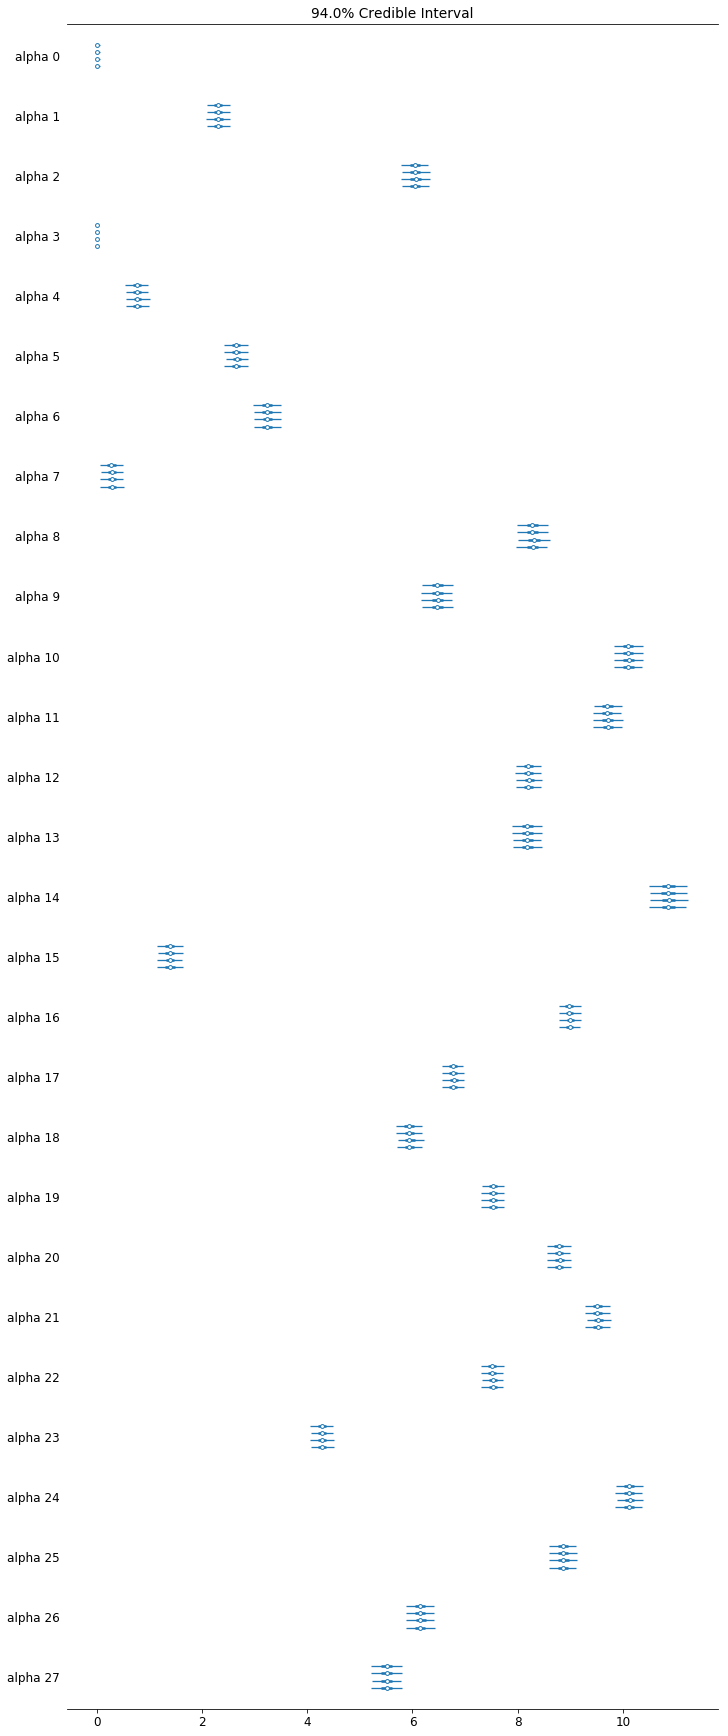

In [30]:
az.plot_forest(trace_m1_continued, var_names=['alpha'], figsize=(10,24), textsize=12)
plt.show()

### Beta values

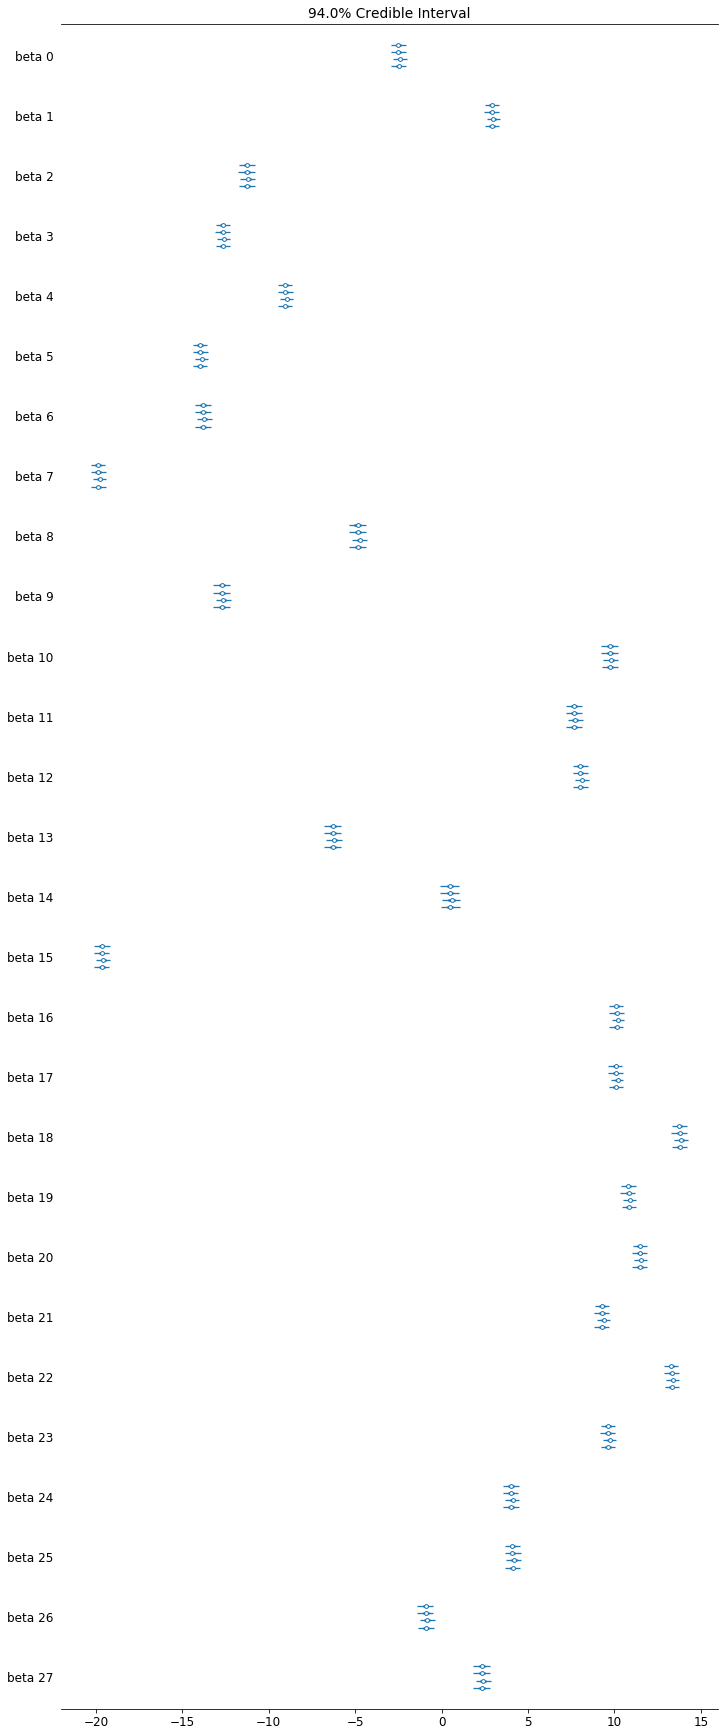

In [31]:
az.plot_forest(trace_m1_continued, var_names=['beta'], figsize=(10,24), textsize=12)
plt.show()

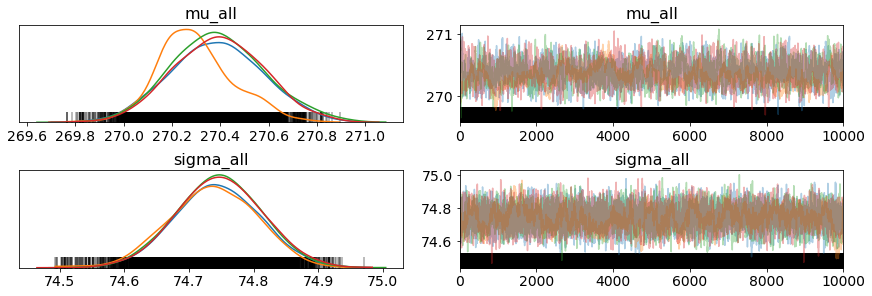

In [34]:
az.plot_trace(trace_m1_continued, var_names=['mu_all', 'sigma_all'])
plt.show()

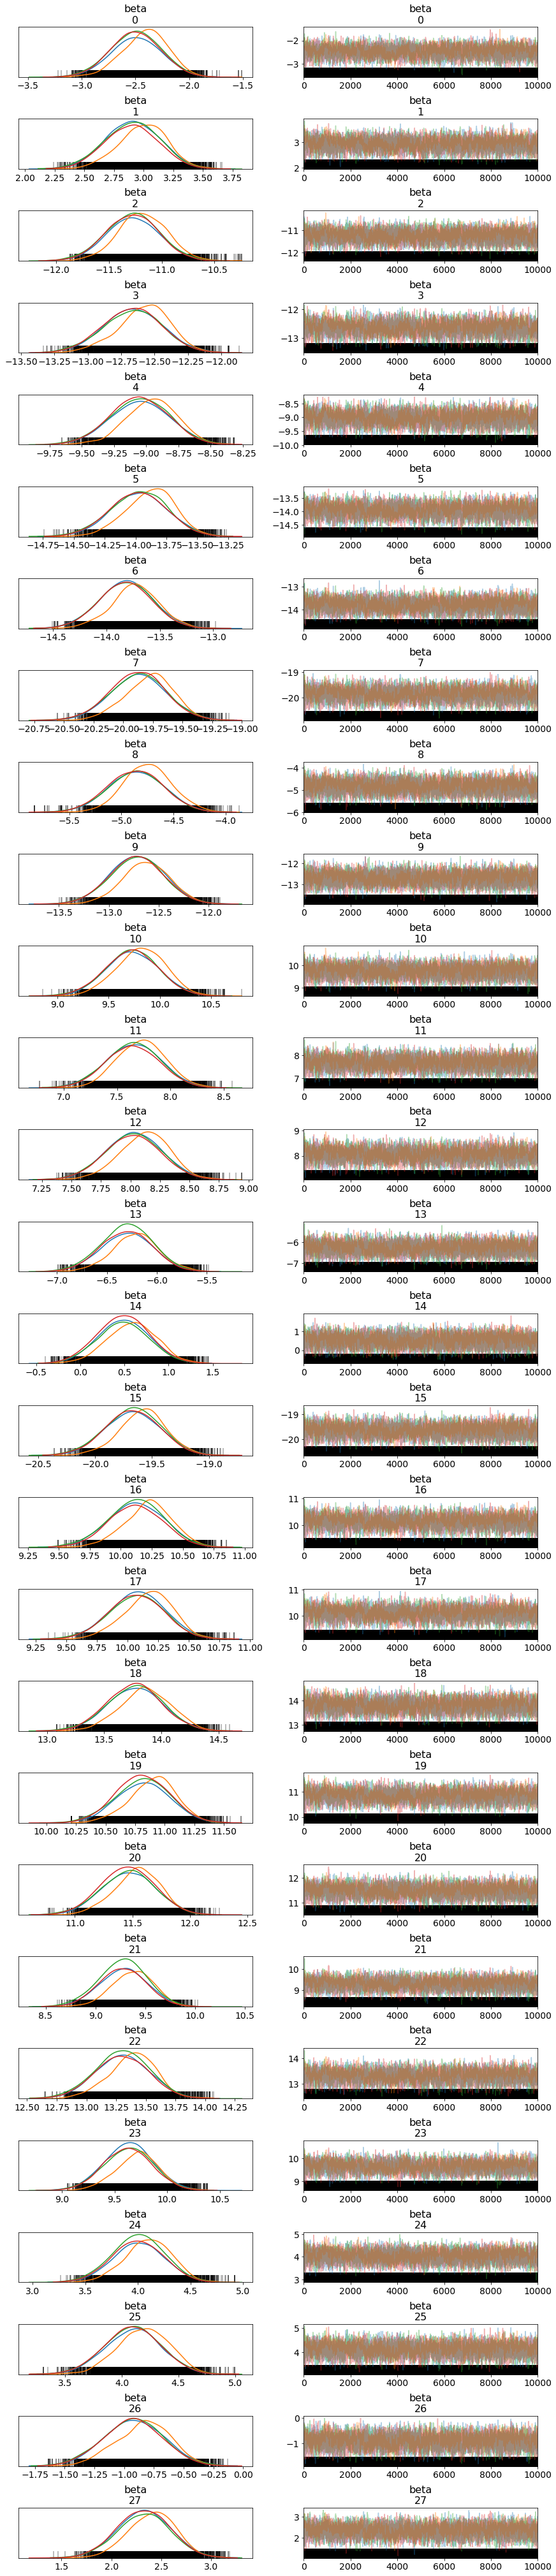

In [35]:
az.plot_trace(trace_m1_continued, var_names=['beta'])
plt.show()

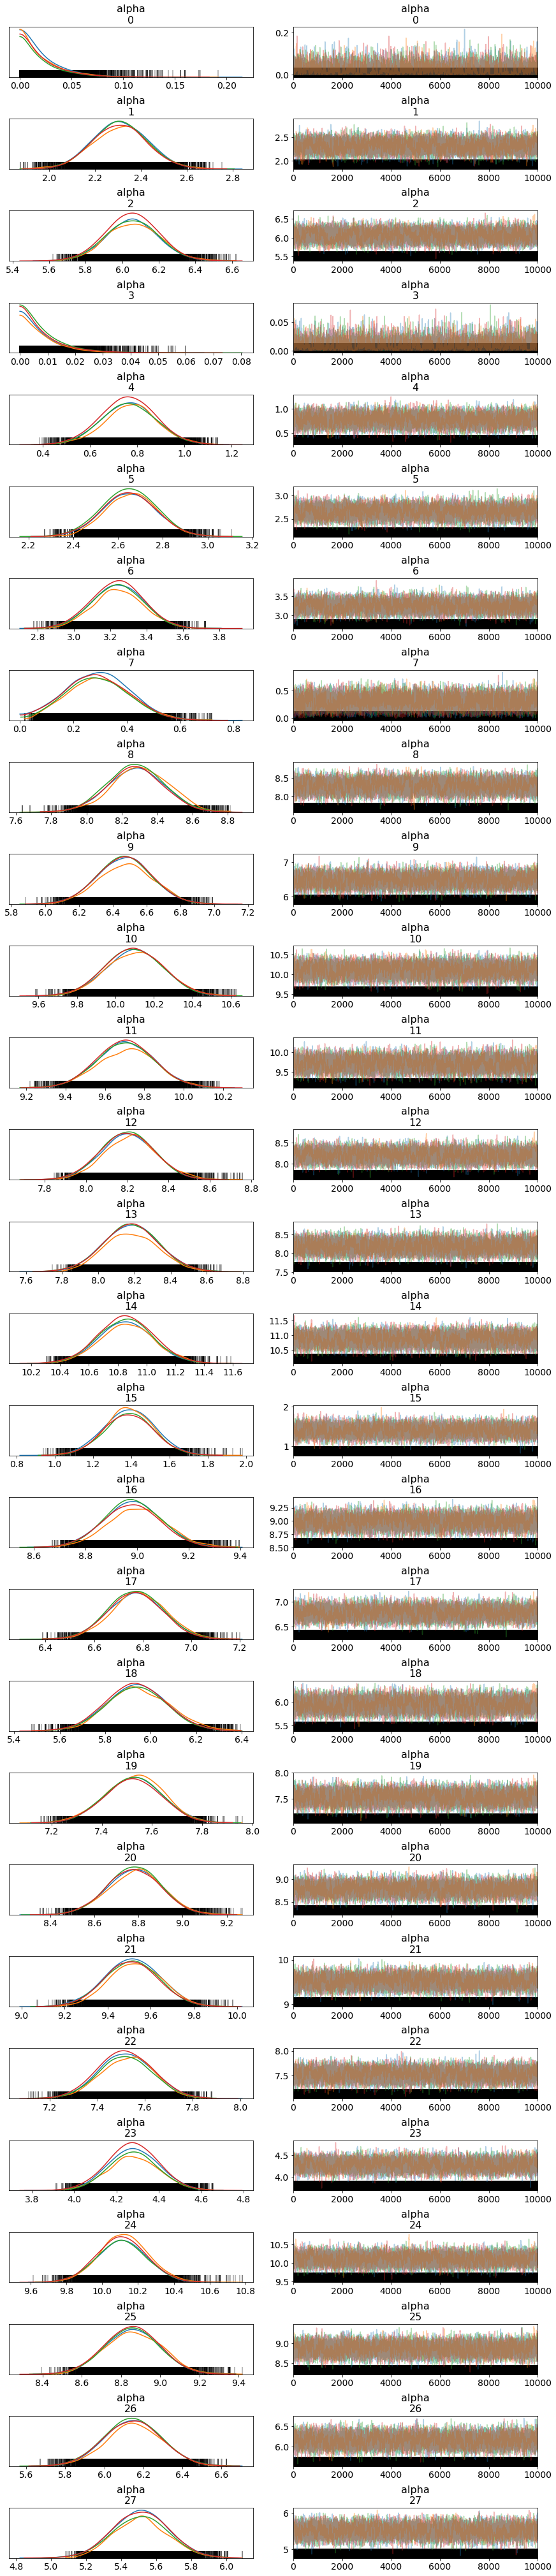

In [36]:
az.plot_trace(trace_m1_continued, var_names=['alpha'])
plt.show()

### Posteriors for intercept parameters

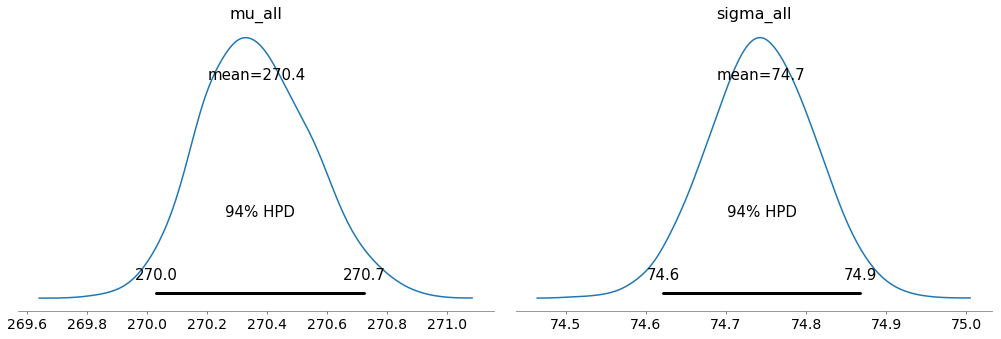

In [32]:
az.plot_posterior(trace_m1_continued, var_names=['mu_all', 'sigma_all'])
plt.show()

## Plot fitted distributions

In [37]:
alpha_hat_full = trace_m1_continued.get_values('alpha').mean(axis=0)
beta_hat_full = trace_m1_continued.get_values('beta').mean(axis=0)
mu_all_hat_full = trace_m1_continued['mu_all'].mean()
sigma_all_hat_full = trace_m1_continued['sigma_all'].mean()

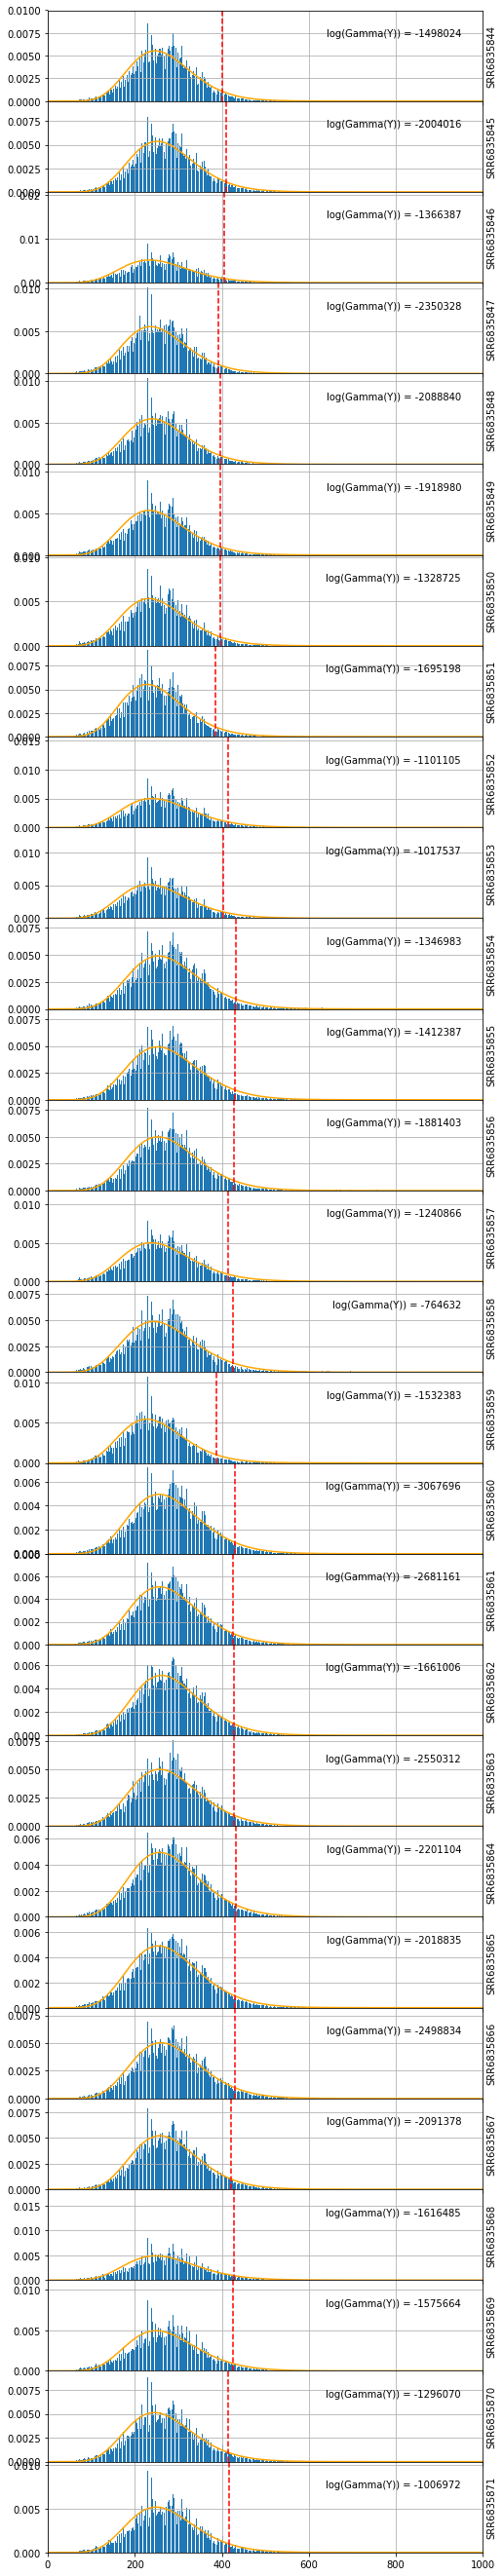

In [38]:
B = data_agg.batch.nunique()
X_plt = np.linspace(0,1000, 200)

f, axs = plt.subplots(B, figsize=(8, 48), sharex='col')
axs[0].set_xlim(left=0, right=1000)

for i in range(B):
    b = data_agg.batch.unique()[i]
    d_b = data_agg.loc[data_agg.batch == b, :]
    axs[i].bar(x=d_b.distance, height=d_b.counts/d_b.counts.sum())
    
    # Fitted Gamma
    a, scale = gamma_reparam(mu_all_hat_full + beta_hat_full[i], sigma_all_hat_full + alpha_hat_full[i])
    Y_plt = stats.gamma(a=a, scale=scale).pdf(X_plt)
    axs[i].plot(X_plt, Y_plt, color='orange')
    
    loglik_gamma = d_b.counts.dot(stats.gamma(a=a, scale=scale).logpdf(d_b.distance))
    axs[i].text(0.95, 0.80, "log(Gamma(Y)) = %d" % loglik_gamma, 
                verticalalignment='top', horizontalalignment='right', 
                transform=axs[i].transAxes)
    
    axs[i].axvline(x=stats.gamma(a=a, scale=scale).isf(0.05), color='r', linestyle='--')
    
    axs[i].set(ylabel=b)
    axs[i].yaxis.set_label_position("right")
    axs[i].grid(True)

f.subplots_adjust(hspace=0)
plt.show()

# Continue Refining

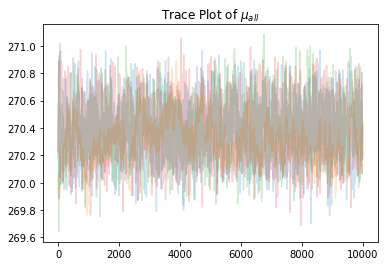

In [40]:
# just checking that the reshaping order I use recapitulates the trace above
plt.plot(trace_m1_continued['mu_all'].reshape((10000,4), order='F'), alpha=0.2)
plt.title("Trace Plot of $\mu_{all}$")
plt.show()

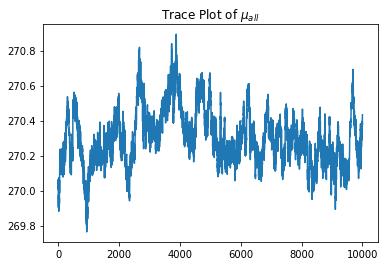

In [46]:
# This is the problematic chain
plt.plot(trace_m1_continued['mu_all'].reshape((10000,4), order='F')[:,1])
plt.title("Trace Plot of $\mu_{all}$")
plt.show()

### Extract Mean Values from Non-DIvergent Chains

In [47]:
alpha_hat = trace_m1_continued.get_values('alpha', combine=True).reshape((10000,4,28), order='F')[:,[0,2,3],:].mean(axis=(0,1))
beta_hat = trace_m1_continued.get_values('beta', combine=True).reshape((10000,4,28), order='F')[:,[0,2,3],:].mean(axis=(0,1))
mu_all_hat = trace_m1_continued['mu_all'].reshape((10000,4), order='F')[:,[0,2,3]].mean()
sigma_all_hat = trace_m1_continued['sigma_all'].reshape((10000,4), order='F')[:,[0,2,3]].mean()



